## Multilayer fully connected network

In [1]:
import numpy as np
import os

# Load data
with np.load(os.path.join('data', 'cifar4-train.npz'), allow_pickle=False) as npz_file:
    # Load items into a dictionary
    cifar = dict(npz_file.items())
    
print('Data loaded')
print('It is a dictionary with keys:', list(cifar.keys()))

Data loaded
It is a dictionary with keys: ['pixels', 'overfeat', 'labels', 'names', 'allow_pickle']


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
    
# Create train set
X_train, X_test, y_train, y_test = train_test_split(
    # Convert uint8 pixel values to float
    cifar['overfeat'].astype(np.float32), cifar['labels'],
    test_size=1800, random_state=0)

# Create validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=1000, random_state=0)

# Rescale input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print('Train:', X_train.shape, y_train.shape)
print('Valid:', X_valid.shape, y_valid.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (3200, 4096) (3200,)
Valid: (800, 4096) (800,)
Test: (1000, 4096) (1000,)


In [3]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In [4]:
import tensorflow as tf

# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 4096])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    
    # Hidden layer with 64 units
    hidden = tf.layers.dense(
        X, 64, activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )
    
    # Create training placeholder
    training = tf.placeholder(dtype=tf.bool)
    
    # Apply dropout
    hidden = tf.layers.dropout(hidden,rate=0.5,seed=0, training=training)
    
    # Output layer
    logits = tf.layers.dense(
        hidden, 4, activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )
    
    # Get weights of the first hidden layer
    with tf.variable_scope('hidden', reuse=True):
        W1 = tf.get_variable('kernel')
        
    # Get weights of the output layer
    with tf.variable_scope('output', reuse=True):
        W2 = tf.get_variable('kernel')
        
    # Loss fuction: mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    # L2 term
    l2_term_1 = tf.nn.l2_loss(W1)
    l2_term_2 = tf.nn.l2_loss(W2)
    
    # Regularization strength
    alpha = tf.placeholder(dtype=tf.float32)
    
    # Loss function
    loss = mean_ce + alpha*(l2_term_1 + l2_term_2)
    
    # Gradient descent
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(loss)
    
    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

In [9]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for epoch in range(50):
        # Accuracy values (train) after each batch
        batch_acc = []
        
        # Get batches of data
        for X_batch, y_batch in get_batches(X_train, y_train, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.01,
                training: True,
                alpha: 0.001
            })
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid,
            y: y_valid,
            training: False
        })
        valid_acc_values.append(valid_acc)
        
        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
                
    # Weights of the hidden layer
    weights_hidden = W1.eval()
    weights_output = W2.eval()

Epoch 1 - valid: 0.783 train: 0.605 (mean)
Epoch 2 - valid: 0.801 train: 0.760 (mean)
Epoch 3 - valid: 0.812 train: 0.797 (mean)
Epoch 4 - valid: 0.814 train: 0.817 (mean)
Epoch 5 - valid: 0.825 train: 0.821 (mean)
Epoch 6 - valid: 0.825 train: 0.839 (mean)
Epoch 7 - valid: 0.831 train: 0.841 (mean)
Epoch 8 - valid: 0.829 train: 0.861 (mean)
Epoch 9 - valid: 0.827 train: 0.869 (mean)
Epoch 10 - valid: 0.831 train: 0.860 (mean)
Epoch 11 - valid: 0.827 train: 0.876 (mean)
Epoch 12 - valid: 0.834 train: 0.882 (mean)
Epoch 13 - valid: 0.834 train: 0.881 (mean)
Epoch 14 - valid: 0.832 train: 0.883 (mean)
Epoch 15 - valid: 0.824 train: 0.887 (mean)
Epoch 16 - valid: 0.826 train: 0.901 (mean)
Epoch 17 - valid: 0.840 train: 0.892 (mean)
Epoch 18 - valid: 0.839 train: 0.899 (mean)
Epoch 19 - valid: 0.835 train: 0.899 (mean)
Epoch 20 - valid: 0.826 train: 0.908 (mean)
Epoch 21 - valid: 0.837 train: 0.907 (mean)
Epoch 22 - valid: 0.839 train: 0.912 (mean)
Epoch 23 - valid: 0.834 train: 0.917 (mea

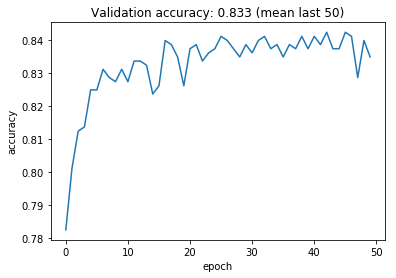

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy: {:.3f} (mean last 50)'.format(
    np.mean(valid_acc_values[-50:])
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

#### Test accuracy

In [13]:
# test accuracy
test_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for epoch in range(50):
        # Accuracy values (test) after each batch
        batch_acc = []
        
        # Get batches of data
        for X_batch, y_batch in get_batches(X_test, y_test, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.01,
                training: True,
                alpha: 0.001
            })
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        test_acc = sess.run(accuracy, feed_dict={
            X: X_test,
            y: y_test,
            training: False
        })
        test_acc_values.append(test_acc)
        
        # Print progress
        print('Epoch {} - test: {:.3f} test: {:.3f} (mean)'.format(
            epoch+1, test_acc, np.mean(batch_acc)
        ))
                
    # Weights of the hidden layer
    weights_hidden = W1.eval()
    weights_output = W2.eval()

Epoch 1 - test: 0.750 test: 0.460 (mean)
Epoch 2 - test: 0.819 test: 0.663 (mean)
Epoch 3 - test: 0.840 test: 0.738 (mean)
Epoch 4 - test: 0.868 test: 0.764 (mean)
Epoch 5 - test: 0.881 test: 0.797 (mean)
Epoch 6 - test: 0.892 test: 0.817 (mean)
Epoch 7 - test: 0.903 test: 0.816 (mean)
Epoch 8 - test: 0.908 test: 0.834 (mean)
Epoch 9 - test: 0.911 test: 0.847 (mean)
Epoch 10 - test: 0.920 test: 0.857 (mean)
Epoch 11 - test: 0.932 test: 0.858 (mean)
Epoch 12 - test: 0.930 test: 0.863 (mean)
Epoch 13 - test: 0.938 test: 0.882 (mean)
Epoch 14 - test: 0.945 test: 0.864 (mean)
Epoch 15 - test: 0.950 test: 0.883 (mean)
Epoch 16 - test: 0.952 test: 0.883 (mean)
Epoch 17 - test: 0.955 test: 0.890 (mean)
Epoch 18 - test: 0.958 test: 0.902 (mean)
Epoch 19 - test: 0.954 test: 0.898 (mean)
Epoch 20 - test: 0.964 test: 0.901 (mean)
Epoch 21 - test: 0.963 test: 0.900 (mean)
Epoch 22 - test: 0.966 test: 0.905 (mean)
Epoch 23 - test: 0.967 test: 0.912 (mean)
Epoch 24 - test: 0.966 test: 0.916 (mean)
E

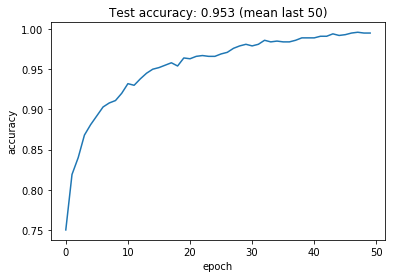

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(test_acc_values)
plt.title('Test accuracy: {:.3f} (mean last 50)'.format(
    np.mean(test_acc_values[-50:])
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()